# Pizza I4 Architecture - Production Experiment Analysis
This notebook analyzes order and pizza production data to identify performance patterns and bottlenecks.

In [1]:
!pip install pandas numpy matplotlib seaborn scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


## 1. Data Loading and Preparation

In [2]:
# Load data
order_df = pd.read_csv('./experiment-data/order_latency.csv')
pizza_df = pd.read_csv('./experiment-data/pizza_latency.csv')

print(f"Original Orders: {len(order_df)}")
print(f"Original Pizzas: {len(pizza_df)}")

# Convert timestamps
for df in [order_df, pizza_df]:
    df['START_TIME'] = pd.to_datetime(df['STARTTIMESTAMP'], unit='ms')
    df['END_TIME'] = pd.to_datetime(df['ENDTIMESTAMP'], unit='ms', errors='coerce')
    
# Calculate latency in seconds
order_df['LATENCY_S'] = (order_df['END_TIME'] - order_df['START_TIME']).dt.total_seconds()
pizza_df['LATENCY_S'] = (pizza_df['END_TIME'] - pizza_df['START_TIME']).dt.total_seconds()

# Separate completed and incomplete
completed_orders = order_df.dropna(subset=['END_TIME']).copy()
incomplete_orders = order_df[order_df['END_TIME'].isna()].copy()

completed_pizzas = pizza_df.dropna(subset=['END_TIME']).copy()
incomplete_pizzas = pizza_df[pizza_df['END_TIME'].isna()].copy()

print(f"\nCompleted Orders: {len(completed_orders)} ({len(completed_orders)/len(order_df)*100:.1f}%)")
print(f"Incomplete Orders: {len(incomplete_orders)} ({len(incomplete_orders)/len(order_df)*100:.1f}%)")
print(f"\nCompleted Pizzas: {len(completed_pizzas)} ({len(completed_pizzas)/len(pizza_df)*100:.1f}%)")
print(f"Incomplete Pizzas: {len(incomplete_pizzas)} ({len(incomplete_pizzas)/len(pizza_df)*100:.1f}%)")

Original Orders: 40
Original Pizzas: 1610

Completed Orders: 40 (100.0%)
Incomplete Orders: 0 (0.0%)

Completed Pizzas: 1610 (100.0%)
Incomplete Pizzas: 0 (0.0%)


## 2. Order-Level Analysis

In [3]:
# Summary statistics
print("=" * 60)
print("ORDER LATENCY STATISTICS (Completed Orders Only)")
print("=" * 60)
print(f"\nMean: {completed_orders['LATENCY_S'].mean():.2f}s")
print(f"Median: {completed_orders['LATENCY_S'].median():.2f}s")
print(f"Std Dev: {completed_orders['LATENCY_S'].std():.2f}s")
print(f"Min: {completed_orders['LATENCY_S'].min():.2f}s")
print(f"Max: {completed_orders['LATENCY_S'].max():.2f}s")

# Percentiles
percentiles = [25, 50, 75, 90, 95, 99]
print("\nPercentiles:")
for p in percentiles:
    val = np.percentile(completed_orders['LATENCY_S'], p)
    print(f"  P{p}: {val:.2f}s")

# Group by order size
print("\n" + "=" * 60)
print("LATENCY BY ORDER SIZE")
print("=" * 60)
size_analysis = completed_orders.groupby('ORDERSIZE').agg({
    'LATENCY_S': ['count', 'mean', 'median', 'std', 'min', 'max']
}).round(2)
size_analysis.columns = ['Count', 'Mean(s)', 'Median(s)', 'Std(s)', 'Min(s)', 'Max(s)']
print(size_analysis)

ORDER LATENCY STATISTICS (Completed Orders Only)

Mean: 153.57s
Median: 124.24s
Std Dev: 138.57s
Min: 14.93s
Max: 430.01s

Percentiles:
  P25: 37.69s
  P50: 124.24s
  P75: 261.89s
  P90: 359.96s
  P95: 373.60s
  P99: 419.04s

LATENCY BY ORDER SIZE
           Count  Mean(s)  Median(s)  Std(s)  Min(s)  Max(s)
ORDERSIZE                                                   
1             10    17.93      18.89    1.92   14.93   19.58
10            10    50.13      46.93    9.97   43.73   78.00
50            10   184.39     177.19   20.84  170.48  240.00
100           10   361.85     352.24   33.02  327.54  430.01


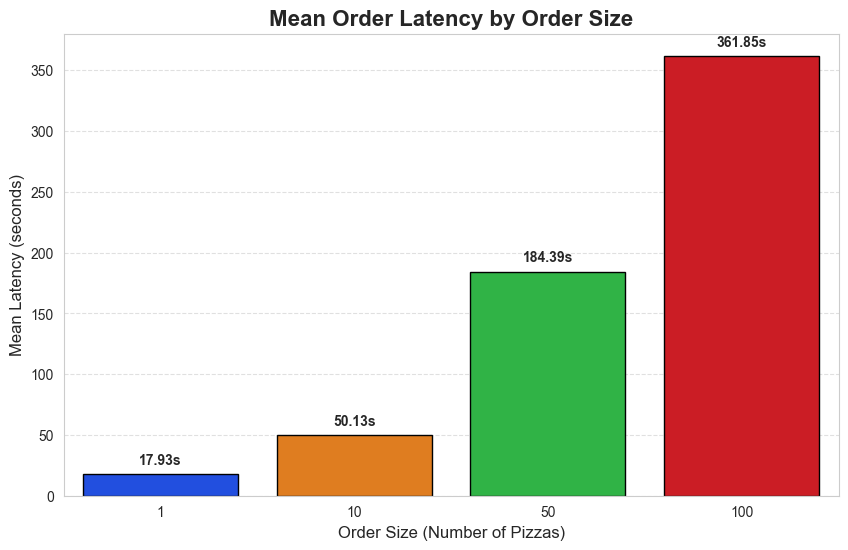

In [4]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=size_analysis.index, y=size_analysis['Mean(s)'], palette='bright', edgecolor='black')

plt.title('Mean Order Latency by Order Size', fontsize=16, fontweight='bold')
plt.xlabel('Order Size (Number of Pizzas)', fontsize=12)
plt.ylabel('Mean Latency (seconds)', fontsize=12)

# Add data labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}s', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

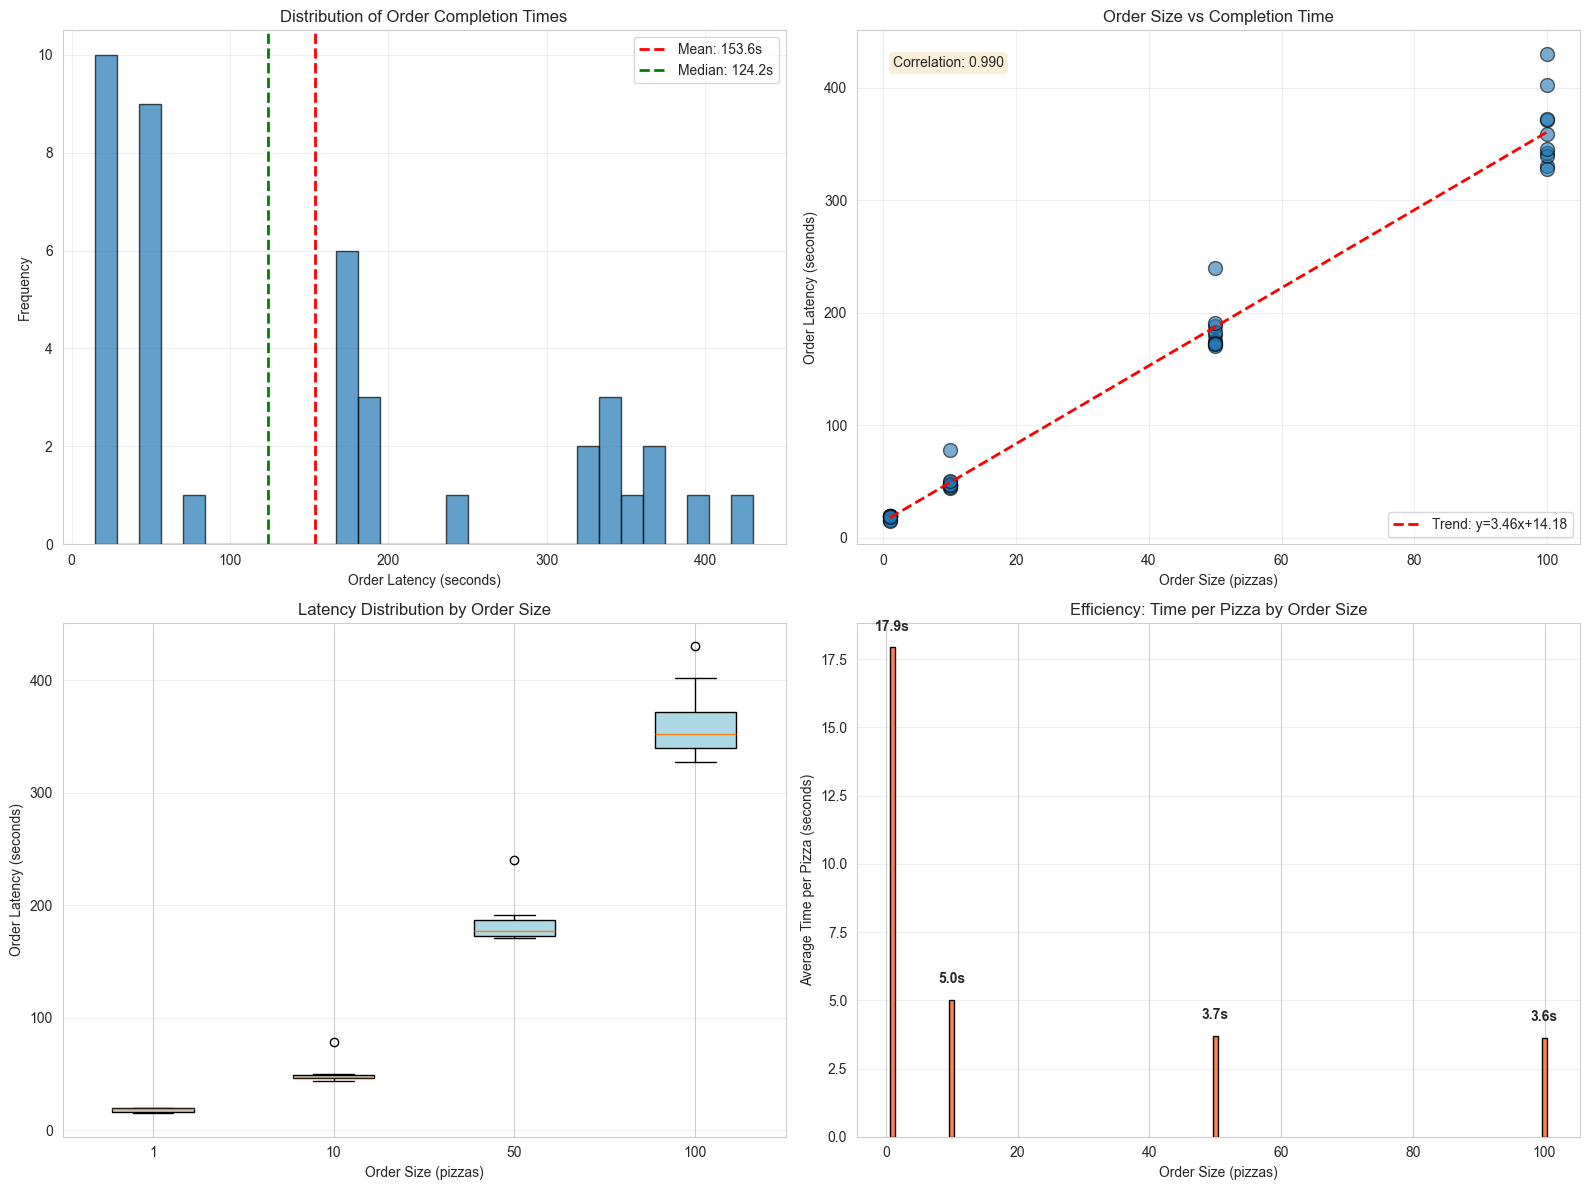

In [5]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of order latency
axes[0, 0].hist(completed_orders['LATENCY_S'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(completed_orders['LATENCY_S'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean: {completed_orders["LATENCY_S"].mean():.1f}s')
axes[0, 0].axvline(completed_orders['LATENCY_S'].median(), color='green', 
                   linestyle='--', linewidth=2, label=f'Median: {completed_orders["LATENCY_S"].median():.1f}s')
axes[0, 0].set_xlabel('Order Latency (seconds)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Order Completion Times')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Order size vs latency (scatter with trend)
axes[0, 1].scatter(completed_orders['ORDERSIZE'], completed_orders['LATENCY_S'], 
                   alpha=0.6, s=100, edgecolors='black')
z = np.polyfit(completed_orders['ORDERSIZE'], completed_orders['LATENCY_S'], 1)
p = np.poly1d(z)
x_line = np.linspace(completed_orders['ORDERSIZE'].min(), completed_orders['ORDERSIZE'].max(), 100)
axes[0, 1].plot(x_line, p(x_line), "r--", linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
axes[0, 1].set_xlabel('Order Size (pizzas)')
axes[0, 1].set_ylabel('Order Latency (seconds)')
axes[0, 1].set_title('Order Size vs Completion Time')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Calculate correlation
corr = completed_orders['ORDERSIZE'].corr(completed_orders['LATENCY_S'])
axes[0, 1].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                transform=axes[0, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Box plot by order size
order_sizes_sorted = sorted(completed_orders['ORDERSIZE'].unique())
data_for_box = [completed_orders[completed_orders['ORDERSIZE'] == size]['LATENCY_S'] 
                for size in order_sizes_sorted]
bp = axes[1, 0].boxplot(data_for_box, labels=order_sizes_sorted, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[1, 0].set_xlabel('Order Size (pizzas)')
axes[1, 0].set_ylabel('Order Latency (seconds)')
axes[1, 0].set_title('Latency Distribution by Order Size')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Average latency per pizza by order size
completed_orders['LATENCY_PER_PIZZA'] = completed_orders['LATENCY_S'] / completed_orders['ORDERSIZE']
avg_per_pizza = completed_orders.groupby('ORDERSIZE')['LATENCY_PER_PIZZA'].mean()
axes[1, 1].bar(avg_per_pizza.index, avg_per_pizza.values, color='coral', edgecolor='black')
axes[1, 1].set_xlabel('Order Size (pizzas)')
axes[1, 1].set_ylabel('Average Time per Pizza (seconds)')
axes[1, 1].set_title('Efficiency: Time per Pizza by Order Size')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, v in enumerate(avg_per_pizza.values):
    axes[1, 1].text(avg_per_pizza.index[i], v + 0.5, f'{v:.1f}s', 
                    ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


## 3. Pizza-Level Analysis

In [6]:
# Merge pizza data with order size
pizza_enriched = completed_pizzas.merge(
    order_df[['ORDERID', 'ORDERSIZE']], 
    left_on='E_ORDER_ID', 
    right_on='ORDERID',
    how='left'
)

print("=" * 60)
print("PIZZA LATENCY STATISTICS")
print("=" * 60)
print(f"\nMean: {pizza_enriched['LATENCY_S'].mean():.2f}s")
print(f"Median: {pizza_enriched['LATENCY_S'].median():.2f}s")
print(f"Std Dev: {pizza_enriched['LATENCY_S'].std():.2f}s")
print(f"Min: {pizza_enriched['LATENCY_S'].min():.2f}s")
print(f"Max: {pizza_enriched['LATENCY_S'].max():.2f}s")

# Analysis by order size
print("\n" + "=" * 60)
print("PIZZA LATENCY BY ORDER SIZE")
print("=" * 60)
pizza_by_size = pizza_enriched.groupby('ORDERSIZE').agg({
    'LATENCY_S': ['count', 'mean', 'median', 'std', 'min', 'max']
}).round(2)
pizza_by_size.columns = ['Count', 'Mean(s)', 'Median(s)', 'Std(s)', 'Min(s)', 'Max(s)']
print(pizza_by_size)

# Add all pizza production latency to get how much time taken to produce all pizzas
pizza_production_time = pizza_enriched['LATENCY_S'].sum()

PIZZA LATENCY STATISTICS

Mean: 27.10s
Median: 21.66s
Std Dev: 14.35s
Min: 14.93s
Max: 122.07s

PIZZA LATENCY BY ORDER SIZE
           Count  Mean(s)  Median(s)  Std(s)  Min(s)  Max(s)
ORDERSIZE                                                   
1             10    17.93      18.89    1.92   14.93   19.58
10           100    21.17      19.23    6.94   15.51   54.83
50           500    25.59      21.93   12.04   15.49  117.06
100         1000    28.54      22.21   15.70   15.48  122.07


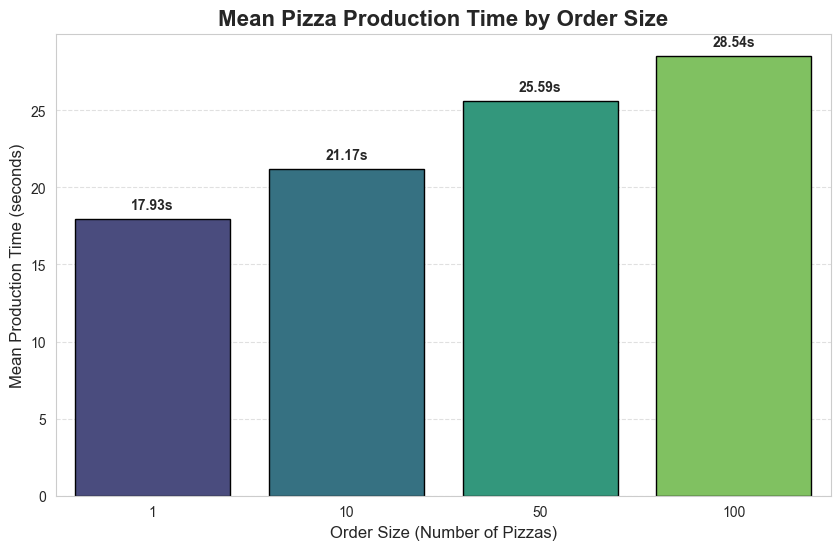

In [7]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=pizza_by_size.index, y=pizza_by_size['Mean(s)'], palette='viridis', edgecolor='black')

plt.title('Mean Pizza Production Time by Order Size', fontsize=16, fontweight='bold')
plt.xlabel('Order Size (Number of Pizzas)', fontsize=12)
plt.ylabel('Mean Production Time (seconds)', fontsize=12)

# Add data labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}s', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()




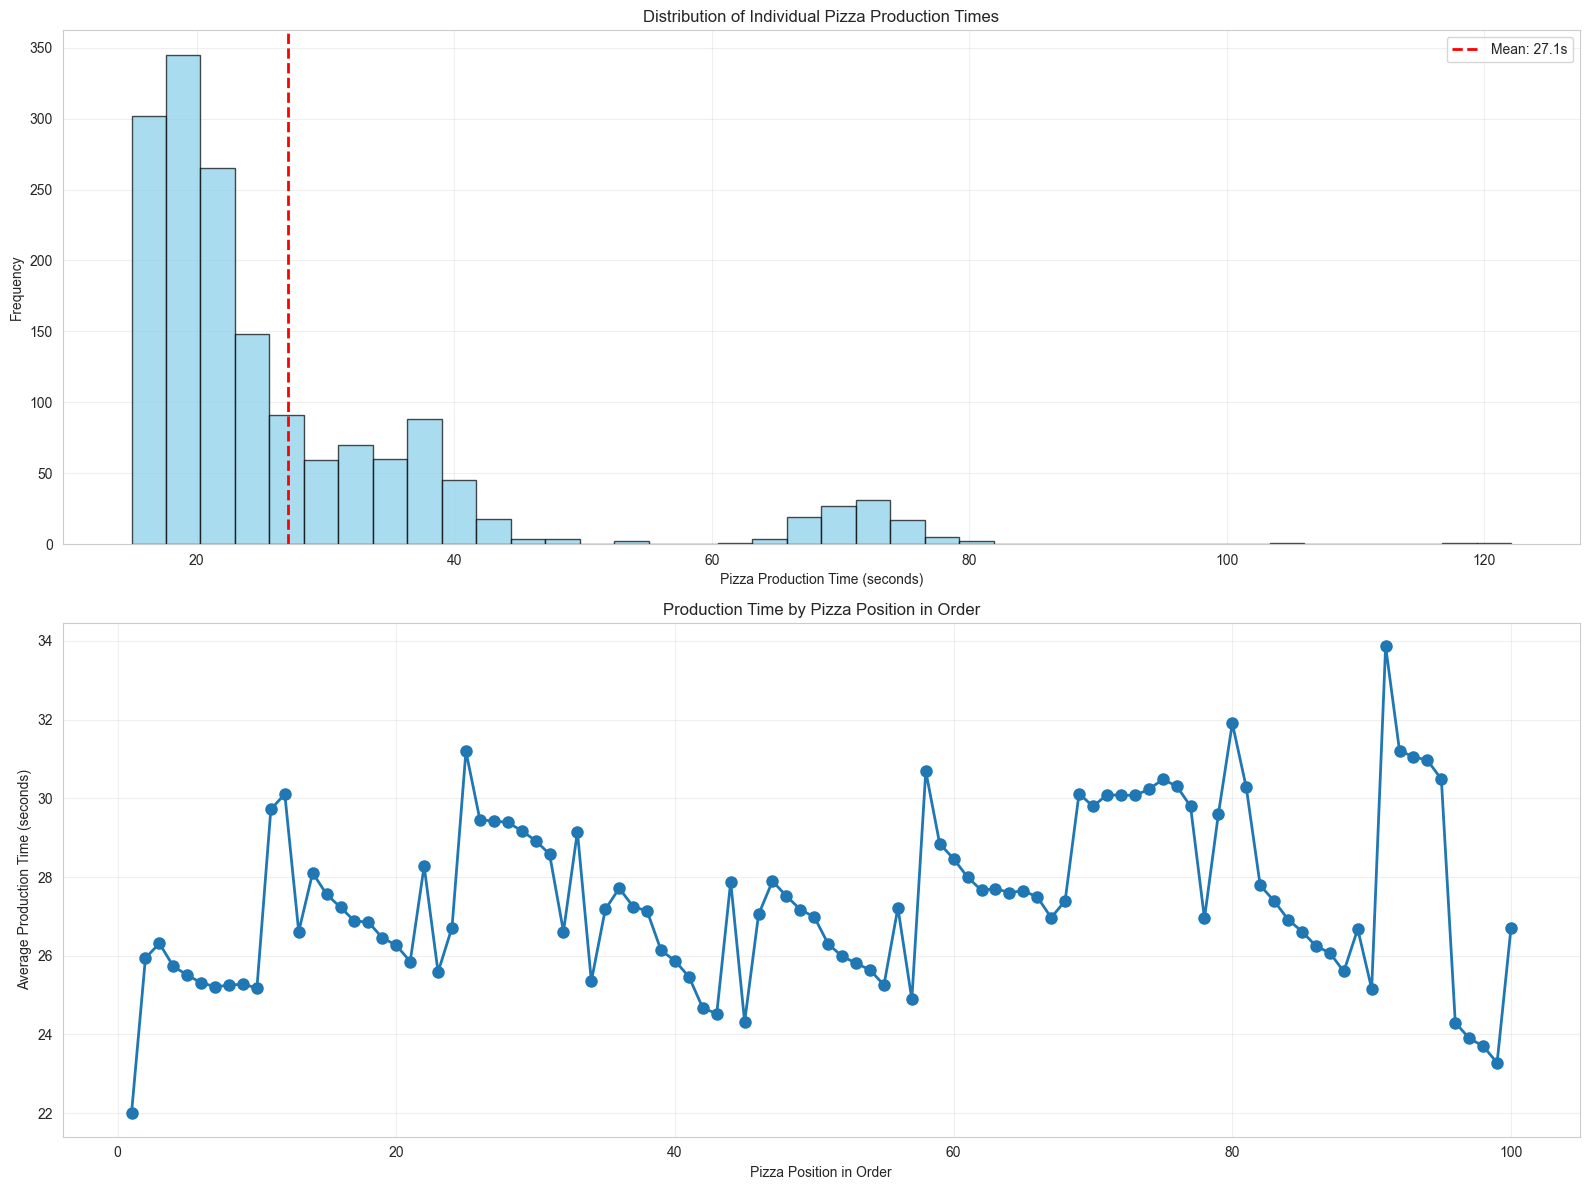

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# 1. Pizza latency distribution
axes[0].hist(pizza_enriched['LATENCY_S'], bins=40, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(pizza_enriched['LATENCY_S'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean: {pizza_enriched["LATENCY_S"].mean():.1f}s')
axes[0].set_xlabel('Pizza Production Time (seconds)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Individual Pizza Production Times')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


# 2. Average pizza time within order (position effect)
pizza_enriched['PIZZA_POSITION'] = pizza_enriched.groupby('E_ORDER_ID').cumcount() + 1
position_analysis = pizza_enriched.groupby('PIZZA_POSITION')['LATENCY_S'].agg(['mean', 'count'])
position_analysis = position_analysis[position_analysis['count'] >= 5]  # Only positions with 5+ samples

axes[1].plot(position_analysis.index, position_analysis['mean'], marker='o', linewidth=2, markersize=8)
axes[1].set_xlabel('Pizza Position in Order')
axes[1].set_ylabel('Average Production Time (seconds)')
axes[1].set_title('Production Time by Pizza Position in Order')
axes[1].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

PIZZA PRODUCTION TIME BY INGREDIENT COUNT

By Total Number of Toppings:
                Count  Mean(s)  Median(s)  Std(s)  Min(s)  Max(s)
TOTAL_TOPPINGS                                                   
2                 325    25.45      21.90   10.61   15.37   71.86
3                 164    21.84      20.02    8.69   15.99   73.40
4                 484    27.07      20.02   16.17   15.26  117.06
5                 323    29.52      22.54   17.14   16.74  122.07
6                 165    28.64      22.74   14.59   14.93   75.71
9                 149    29.62      26.23   11.00   18.75  104.14

--------------------------------------------------------------------------------
By Number of Cheese Types:
            Count  Mean(s)  Median(s)  Std(s)
NUM_CHEESE                                   
1             642    25.36      20.84   12.06
2             827    28.32      22.59   15.38
4             141    27.88      20.81   16.73

------------------------------------------------------------

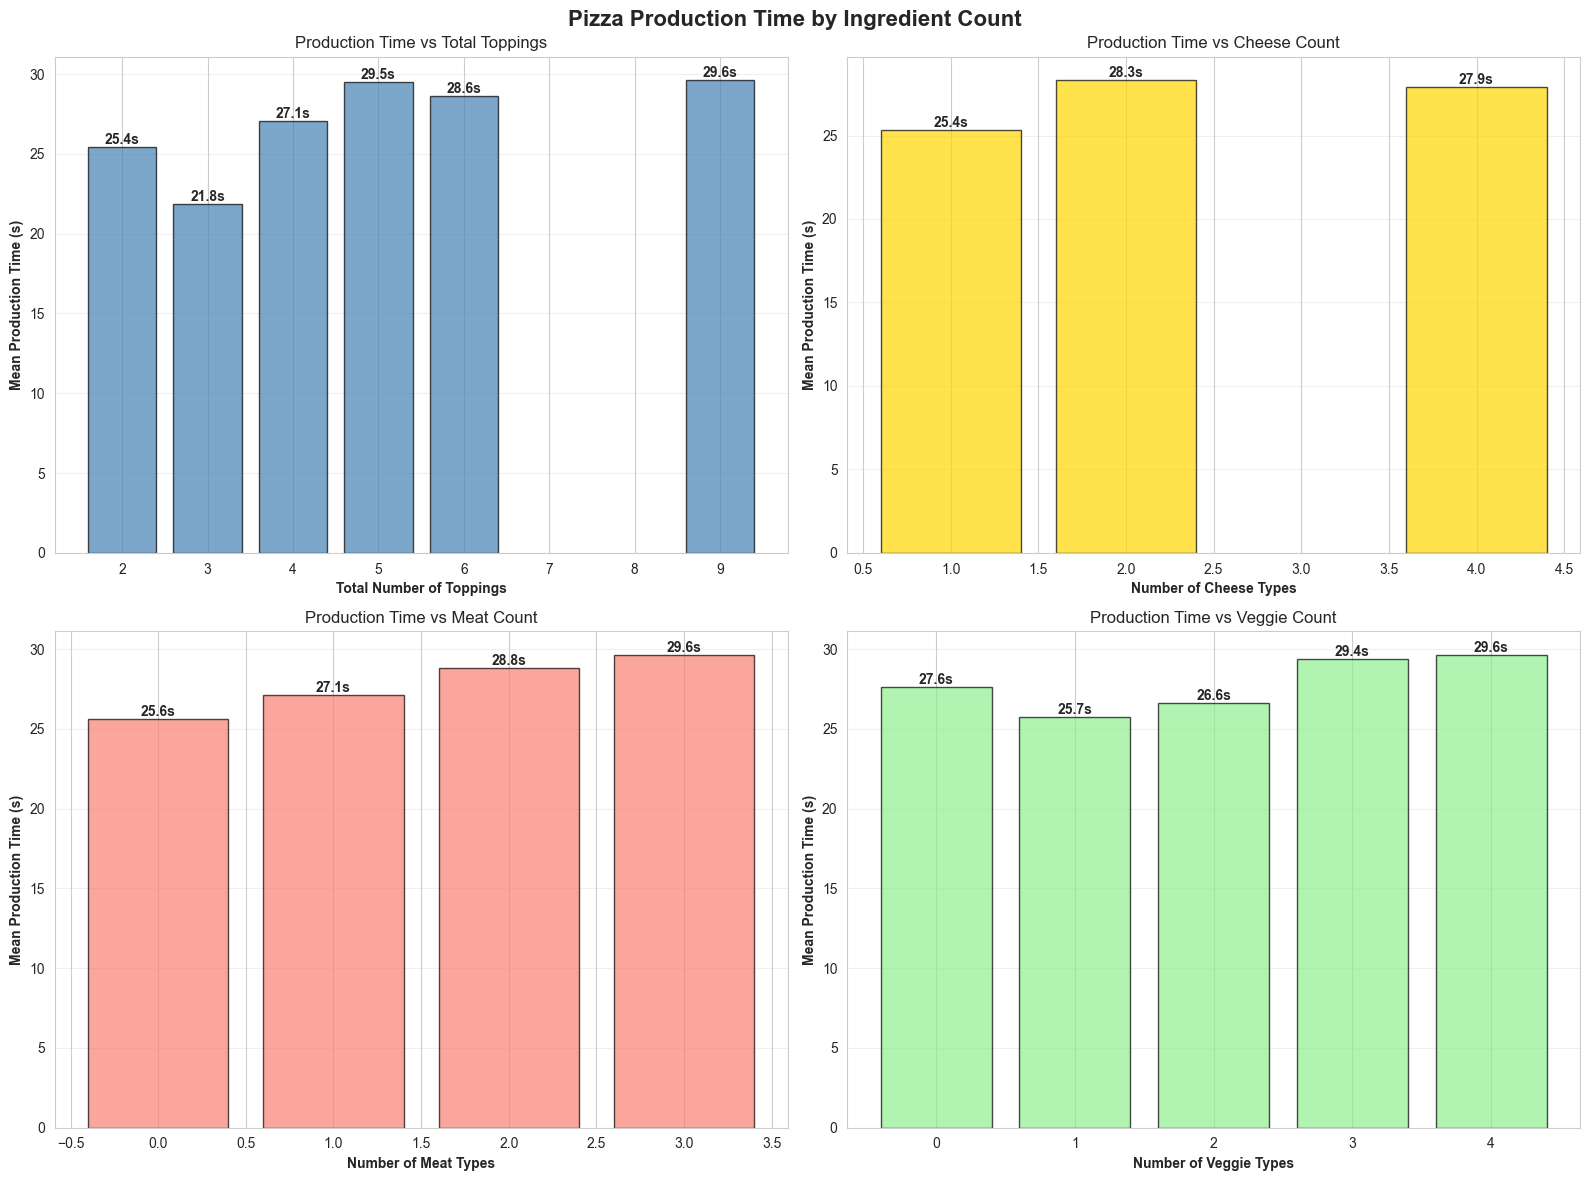


MOST TIME-CONSUMING INGREDIENTS

Cheese Types (avg production time, min 5 samples):
  jalapeño jack                 : 29.67s (n=152)
  feta                          : 29.39s (n=171)
  cheddar                       : 29.11s (n=314)
  provolone                     : 27.88s (n=141)
  parmesan                      : 27.88s (n=141)
  gorgonzola                    : 27.88s (n=141)
  mozzarella                    : 27.10s (n=1610)
  smoked provolone              : 24.97s (n=190)

Meat Types (avg production time, min 5 samples):
  ground beef                   : 29.67s (n=152)
  ham                           : 29.28s (n=302)
  sausage                       : 29.11s (n=314)
  bacon                         : 28.78s (n=318)
  pepperoni                     : 28.44s (n=308)
  grilled chicken               : 24.97s (n=190)

Veggie Types (avg production time, min 5 samples):
  jalapeño                      : 29.67s (n=152)
  red bell pepper               : 29.67s (n=152)
  onion                     

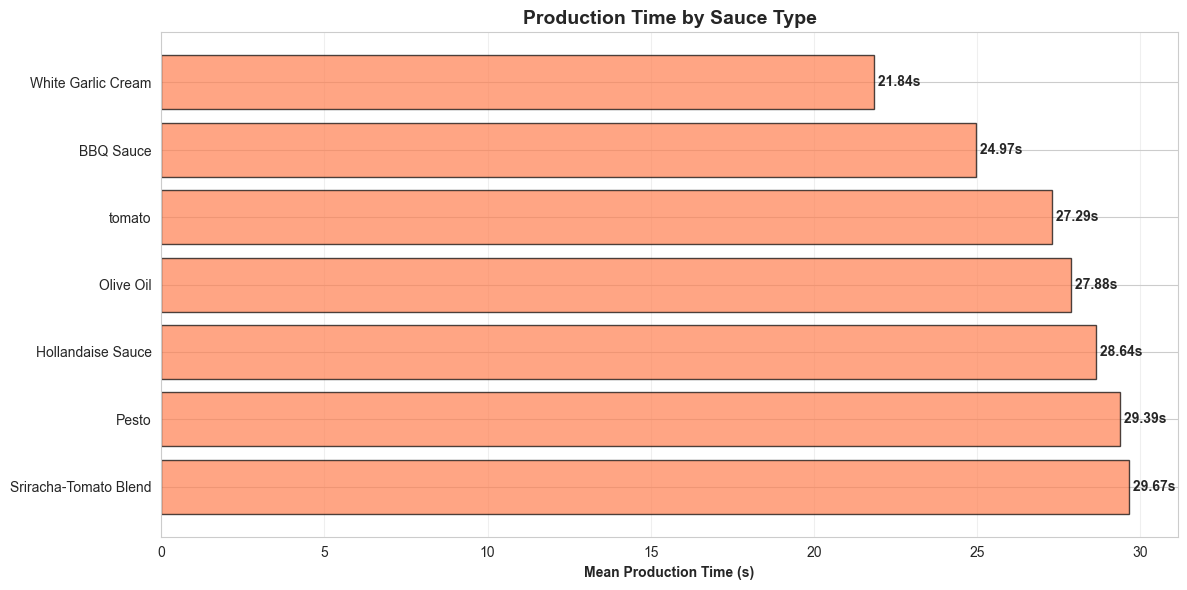


BAKED VS UNBAKED PIZZAS
         Count  Mean(s)  Median(s)  Std(s)
Unbaked   1100    27.87      21.64   15.27
Baked      510    25.44      21.77   11.98


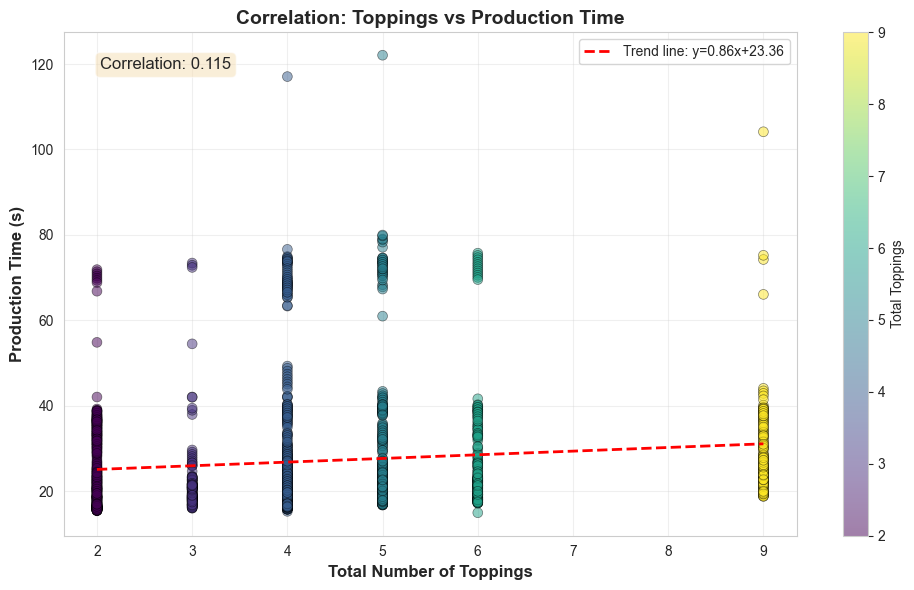

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast


# Convert latency to seconds
pizza_df['LATENCY_S'] = pizza_df['LATENCYMS'] / 1000

# Parse ingredient lists (they're stored as strings that look like lists)
def safe_parse_list(val):
    """Safely parse string representations of lists"""
    if pd.isna(val) or val == '[]':
        return []
    try:
        # Handle both ['item'] and "['item']" formats
        if isinstance(val, str):
            return ast.literal_eval(val)
        return val
    except:
        return []

pizza_df['CHEESE_LIST'] = pizza_df['CHEESE'].apply(safe_parse_list)
pizza_df['MEAT_LIST'] = pizza_df['MEAT'].apply(safe_parse_list)
pizza_df['VEGGIES_LIST'] = pizza_df['VEGGIES'].apply(safe_parse_list)

# Count ingredients
pizza_df['NUM_CHEESE'] = pizza_df['CHEESE_LIST'].apply(len)
pizza_df['NUM_MEAT'] = pizza_df['MEAT_LIST'].apply(len)
pizza_df['NUM_VEGGIES'] = pizza_df['VEGGIES_LIST'].apply(len)
pizza_df['TOTAL_TOPPINGS'] = pizza_df['NUM_CHEESE'] + pizza_df['NUM_MEAT'] + pizza_df['NUM_VEGGIES']

# ============================================================================
# 1. INGREDIENT COUNT ANALYSIS
# ============================================================================
print("=" * 80)
print("PIZZA PRODUCTION TIME BY INGREDIENT COUNT")
print("=" * 80)

# Overall statistics by total toppings
print("\nBy Total Number of Toppings:")
toppings_stats = pizza_df.groupby('TOTAL_TOPPINGS').agg({
    'LATENCY_S': ['count', 'mean', 'median', 'std', 'min', 'max']
}).round(2)
toppings_stats.columns = ['Count', 'Mean(s)', 'Median(s)', 'Std(s)', 'Min(s)', 'Max(s)']
print(toppings_stats)

# By cheese count
print("\n" + "-" * 80)
print("By Number of Cheese Types:")
cheese_stats = pizza_df.groupby('NUM_CHEESE').agg({
    'LATENCY_S': ['count', 'mean', 'median', 'std']
}).round(2)
cheese_stats.columns = ['Count', 'Mean(s)', 'Median(s)', 'Std(s)']
print(cheese_stats)

# By meat count
print("\n" + "-" * 80)
print("By Number of Meat Types:")
meat_stats = pizza_df.groupby('NUM_MEAT').agg({
    'LATENCY_S': ['count', 'mean', 'median', 'std']
}).round(2)
meat_stats.columns = ['Count', 'Mean(s)', 'Median(s)', 'Std(s)']
print(meat_stats)

# By veggie count
print("\n" + "-" * 80)
print("By Number of Veggie Types:")
veggie_stats = pizza_df.groupby('NUM_VEGGIES').agg({
    'LATENCY_S': ['count', 'mean', 'median', 'std']
}).round(2)
veggie_stats.columns = ['Count', 'Mean(s)', 'Median(s)', 'Std(s)']
print(veggie_stats)

# ============================================================================
# 2. VISUALIZATIONS - INGREDIENT COUNT IMPACT
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Pizza Production Time by Ingredient Count', fontsize=16, fontweight='bold')

# Total toppings
ax1 = axes[0, 0]
toppings_grouped = pizza_df.groupby('TOTAL_TOPPINGS')['LATENCY_S'].mean()
bars1 = ax1.bar(toppings_grouped.index, toppings_grouped.values, 
                edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_xlabel('Total Number of Toppings', fontweight='bold')
ax1.set_ylabel('Mean Production Time (s)', fontweight='bold')
ax1.set_title('Production Time vs Total Toppings')
ax1.grid(axis='y', alpha=0.3)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')

# Cheese count
ax2 = axes[0, 1]
cheese_grouped = pizza_df.groupby('NUM_CHEESE')['LATENCY_S'].mean()
bars2 = ax2.bar(cheese_grouped.index, cheese_grouped.values, 
                edgecolor='black', alpha=0.7, color='gold')
ax2.set_xlabel('Number of Cheese Types', fontweight='bold')
ax2.set_ylabel('Mean Production Time (s)', fontweight='bold')
ax2.set_title('Production Time vs Cheese Count')
ax2.grid(axis='y', alpha=0.3)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')

# Meat count
ax3 = axes[1, 0]
meat_grouped = pizza_df.groupby('NUM_MEAT')['LATENCY_S'].mean()
bars3 = ax3.bar(meat_grouped.index, meat_grouped.values, 
                edgecolor='black', alpha=0.7, color='salmon')
ax3.set_xlabel('Number of Meat Types', fontweight='bold')
ax3.set_ylabel('Mean Production Time (s)', fontweight='bold')
ax3.set_title('Production Time vs Meat Count')
ax3.grid(axis='y', alpha=0.3)
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')

# Veggie count
ax4 = axes[1, 1]
veggie_grouped = pizza_df.groupby('NUM_VEGGIES')['LATENCY_S'].mean()
bars4 = ax4.bar(veggie_grouped.index, veggie_grouped.values, 
                edgecolor='black', alpha=0.7, color='lightgreen')
ax4.set_xlabel('Number of Veggie Types', fontweight='bold')
ax4.set_ylabel('Mean Production Time (s)', fontweight='bold')
ax4.set_title('Production Time vs Veggie Count')
ax4.grid(axis='y', alpha=0.3)
for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# 3. INDIVIDUAL INGREDIENT ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("MOST TIME-CONSUMING INGREDIENTS")
print("=" * 80)

# Analyze individual cheese types
cheese_impact = {}
for idx, row in pizza_df.iterrows():
    for cheese in row['CHEESE_LIST']:
        if cheese not in cheese_impact:
            cheese_impact[cheese] = []
        cheese_impact[cheese].append(row['LATENCY_S'])

cheese_avg = {k: np.mean(v) for k, v in cheese_impact.items() if len(v) >= 5}
cheese_sorted = sorted(cheese_avg.items(), key=lambda x: x[1], reverse=True)

print("\nCheese Types (avg production time, min 5 samples):")
for cheese, avg_time in cheese_sorted[:10]:
    count = len(cheese_impact[cheese])
    print(f"  {cheese:30s}: {avg_time:.2f}s (n={count})")

# Analyze individual meat types
meat_impact = {}
for idx, row in pizza_df.iterrows():
    for meat in row['MEAT_LIST']:
        if meat not in meat_impact:
            meat_impact[meat] = []
        meat_impact[meat].append(row['LATENCY_S'])

meat_avg = {k: np.mean(v) for k, v in meat_impact.items() if len(v) >= 5}
meat_sorted = sorted(meat_avg.items(), key=lambda x: x[1], reverse=True)

print("\nMeat Types (avg production time, min 5 samples):")
for meat, avg_time in meat_sorted[:10]:
    count = len(meat_impact[meat])
    print(f"  {meat:30s}: {avg_time:.2f}s (n={count})")

# Analyze individual veggie types
veggie_impact = {}
for idx, row in pizza_df.iterrows():
    for veggie in row['VEGGIES_LIST']:
        if veggie not in veggie_impact:
            veggie_impact[veggie] = []
        veggie_impact[veggie].append(row['LATENCY_S'])

veggie_avg = {k: np.mean(v) for k, v in veggie_impact.items() if len(v) >= 5}
veggie_sorted = sorted(veggie_avg.items(), key=lambda x: x[1], reverse=True)

print("\nVeggie Types (avg production time, min 5 samples):")
for veggie, avg_time in veggie_sorted[:10]:
    count = len(veggie_impact[veggie])
    print(f"  {veggie:30s}: {avg_time:.2f}s (n={count})")

# ============================================================================
# 4. SAUCE TYPE ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("PRODUCTION TIME BY SAUCE TYPE")
print("=" * 80)

sauce_stats = pizza_df.groupby('SAUCE').agg({
    'LATENCY_S': ['count', 'mean', 'median', 'std']
}).round(2)
sauce_stats.columns = ['Count', 'Mean(s)', 'Median(s)', 'Std(s)']
sauce_stats = sauce_stats.sort_values('Mean(s)', ascending=False)
print(sauce_stats)

# Visualize sauce impact
fig, ax = plt.subplots(figsize=(12, 6))
sauce_grouped = pizza_df.groupby('SAUCE')['LATENCY_S'].mean().sort_values(ascending=False)
bars = ax.barh(range(len(sauce_grouped)), sauce_grouped.values, 
               edgecolor='black', alpha=0.7, color='coral')
ax.set_yticks(range(len(sauce_grouped)))
ax.set_yticklabels(sauce_grouped.index)
ax.set_xlabel('Mean Production Time (s)', fontweight='bold')
ax.set_title('Production Time by Sauce Type', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f' {width:.2f}s', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# 5. BAKED VS UNBAKED ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("BAKED VS UNBAKED PIZZAS")
print("=" * 80)

baked_stats = pizza_df.groupby('BAKED').agg({
    'LATENCY_S': ['count', 'mean', 'median', 'std']
}).round(2)
baked_stats.columns = ['Count', 'Mean(s)', 'Median(s)', 'Std(s)']
baked_stats.index = ['Unbaked', 'Baked']
print(baked_stats)

# ============================================================================
# 6. CORRELATION ANALYSIS
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(pizza_df['TOTAL_TOPPINGS'], pizza_df['LATENCY_S'], 
                     alpha=0.5, s=50, c=pizza_df['TOTAL_TOPPINGS'], 
                     cmap='viridis', edgecolors='black', linewidth=0.5)
ax.set_xlabel('Total Number of Toppings', fontweight='bold', fontsize=12)
ax.set_ylabel('Production Time (s)', fontweight='bold', fontsize=12)
ax.set_title('Correlation: Toppings vs Production Time', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

# Add trend line
z = np.polyfit(pizza_df['TOTAL_TOPPINGS'], pizza_df['LATENCY_S'], 1)
p = np.poly1d(z)
ax.plot(pizza_df['TOTAL_TOPPINGS'].sort_values().unique(), 
        p(pizza_df['TOTAL_TOPPINGS'].sort_values().unique()), 
        "r--", linewidth=2, label=f'Trend line: y={z[0]:.2f}x+{z[1]:.2f}')
ax.legend()

# Calculate correlation
correlation = pizza_df['TOTAL_TOPPINGS'].corr(pizza_df['LATENCY_S'])
ax.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
        transform=ax.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.colorbar(scatter, label='Total Toppings', ax=ax)
plt.tight_layout()
plt.show()



## 4. Order vs Pizza Comparison

In [10]:
# Compare total order time vs sum of pizza times
pizza_sum_by_order = pizza_enriched.groupby('E_ORDER_ID')['LATENCY_S'].sum().reset_index()
pizza_sum_by_order.columns = ['ORDERID', 'TOTAL_PIZZA_TIME']

comparison = completed_orders[['ORDERID', 'ORDERSIZE', 'LATENCY_S']].merge(
    pizza_sum_by_order, on='ORDERID', how='inner'
)
comparison['TIME_DIFFERENCE'] = comparison['LATENCY_S'] - comparison['TOTAL_PIZZA_TIME']
comparison['EFFICIENCY_RATIO'] = comparison['TOTAL_PIZZA_TIME'] / comparison['LATENCY_S']

print("=" * 60)
print("ORDER EFFICIENCY ANALYSIS")
print("=" * 60)
print("\nOrders where total pizza time < order time (parallel production):")
print(comparison[comparison['TIME_DIFFERENCE'] > 0][['ORDERID', 'ORDERSIZE', 'TIME_DIFFERENCE', 'EFFICIENCY_RATIO']])

print(f"\nAverage efficiency ratio: {comparison['EFFICIENCY_RATIO'].mean():.2f}")
print(f"(Ratio > 1 indicates sequential production, < 1 indicates parallel production)")

ORDER EFFICIENCY ANALYSIS

Orders where total pizza time < order time (parallel production):
                                 ORDERID  ORDERSIZE  TIME_DIFFERENCE  \
4   138060e2-9a98-4355-8ade-247df73e1e4b          1            0.001   
6   16a23836-01fa-4efe-996c-184dd6c7fc0b          1            0.002   
8   24e5cb68-1591-4aa4-8c10-a986340a6e94          1            0.001   
13  699f8818-16ef-407e-a66e-b8fc8614b29d          1            0.029   
17  8435f9ed-f46c-4cec-8ac7-747d5a88ab9c          1            0.001   
35  db09885d-48bd-4eb2-afd7-92ca3c263d32          1            0.001   

    EFFICIENCY_RATIO  
4           0.999949  
6           0.999897  
8           0.999948  
13          0.998117  
17          0.999934  
35          0.999947  

Average efficiency ratio: 4.96
(Ratio > 1 indicates sequential production, < 1 indicates parallel production)


## 5. Key Findings & Recommendations

In [11]:
print("=" * 70)
print(" " * 20 + "KEY FINDINGS")
print("=" * 70)

# 1. Completion rate
order_completion = len(completed_orders) / len(order_df) * 100
pizza_completion = len(completed_pizzas) / len(pizza_df) * 100
print(f"\n1. COMPLETION RATES:")
print(f"   • Orders: {order_completion:.1f}% completed")
print(f"   • Pizzas: {pizza_completion:.1f}% completed")
if order_completion < 90 or pizza_completion < 90:
    print("   ⚠ WARNING: Low completion rate may indicate system issues")

# 2. Scalability
corr = completed_orders['ORDERSIZE'].corr(completed_orders['LATENCY_S'])
print(f"\n2. SCALABILITY:")
print(f"   • Correlation (size vs time): {corr:.3f}")
if corr > 0.7:
    print("   ⚠ Strong positive correlation - system may not scale well")
elif corr > 0.4:
    print("   ⚠ Moderate correlation - some scalability concerns")
else:
    print("   ✓ Low correlation - good scalability")

# 3. Parallelization
avg_efficiency = comparison['EFFICIENCY_RATIO'].mean()
print(f"\n3. PARALLELIZATION EFFICIENCY:")
print(f"   • Average efficiency ratio: {avg_efficiency:.2f}")
if avg_efficiency > 1.2:
    print("   ⚠ Mostly sequential production - limited parallelization")
elif avg_efficiency > 0.8:
    print("   → Partial parallelization achieved")
else:
    print("   ✓ Good parallelization - efficient use of resources")

# 4. Bottlenecks
largest_orders = completed_orders.nlargest(3, 'ORDERSIZE')
print(f"\n4. POTENTIAL BOTTLENECKS:")
for _, order in largest_orders.iterrows():
    time_per_pizza = order['LATENCY_S'] / order['ORDERSIZE']
    print(f"   • Order {(order['ORDERID'])} ({int(order['ORDERSIZE'])} pizzas): {time_per_pizza:.1f}s per pizza")

# 5. Recommendations
print(f"\n5. RECOMMENDATIONS:")
if corr > 0.6:
    print("   → Consider adding more parallel processing capacity")
if avg_efficiency > 1.0:
    print("   → Optimize pizza production pipeline for better parallelization")
if pizza_completion < 95:
    print("   → Investigate causes of incomplete pizzas/orders")
if completed_orders['LATENCY_PER_PIZZA'].std() > completed_orders['LATENCY_PER_PIZZA'].mean() * 0.5:
    print("   → High variability in per-pizza time - investigate consistency issues")

print("\n" + "=" * 70)

                    KEY FINDINGS

1. COMPLETION RATES:
   • Orders: 100.0% completed
   • Pizzas: 100.0% completed

2. SCALABILITY:
   • Correlation (size vs time): 0.990
   ⚠ Strong positive correlation - system may not scale well

3. PARALLELIZATION EFFICIENCY:
   • Average efficiency ratio: 4.96
   ⚠ Mostly sequential production - limited parallelization

4. POTENTIAL BOTTLENECKS:
   • Order 2850e648-6f46-4d54-8682-47bce1dc2544 (100 pizzas): 4.3s per pizza
   • Order 33c24aba-e9e3-4fc7-a835-11d56a4b8049 (100 pizzas): 4.0s per pizza
   • Order 58a71607-81e2-4e4e-920c-17856821b504 (100 pizzas): 3.7s per pizza

5. RECOMMENDATIONS:
   → Consider adding more parallel processing capacity
   → Optimize pizza production pipeline for better parallelization
   → High variability in per-pizza time - investigate consistency issues



## 6 Restocking Analysis

In [12]:
# Load data
dough_df = pd.read_csv('./experiment-data/dough_machine_restock_latency.csv')
sauce_df = pd.read_csv('./experiment-data/sauce_machine_restock_latency.csv')
cheese_df = pd.read_csv('./experiment-data/cheese_machine_restock_latency.csv')
meat_df = pd.read_csv('./experiment-data/meat_machine_restock_latency.csv')
vegetables_df = pd.read_csv('./experiment-data/vegetables_machine_restock_latency.csv')
packaging_df = pd.read_csv('./experiment-data/packaging_machine_restock_latency.csv')

# Convert milliseconds to seconds for all dataframes
for df in [dough_df, sauce_df, cheese_df, meat_df, vegetables_df, packaging_df]:
    df['RESTOCKLATENCYSEC'] = df['RESTOCKLATENCYMS'] / 1000


# Combine all dataframes
all_machines = {
    'dough': dough_df,
    'sauce': sauce_df,
    'cheese': cheese_df,
    'meat': meat_df,
    'vegetables': vegetables_df,
    'packaging': packaging_df
}

In [13]:
# ============================================================================
# 1. BASIC STATISTICS PER MACHINE
# ============================================================================
print("=" * 80)
print("RESTOCK LATENCY ANALYSIS - SUMMARY STATISTICS")
print("=" * 80)

summary_stats = []
for machine_name, df in all_machines.items():
    stats = {
        'Machine': machine_name,
        'Count': len(df),
        'Mean (s)': df['RESTOCKLATENCYSEC'].mean(),
        'Median (s)': df['RESTOCKLATENCYSEC'].median(),
        'Std Dev (s)': df['RESTOCKLATENCYSEC'].std(),
        'Min (s)': df['RESTOCKLATENCYSEC'].min(),
        'Max (s)': df['RESTOCKLATENCYSEC'].max(),
        'P95 (s)': df['RESTOCKLATENCYSEC'].quantile(0.95),
        'P99 (s)': df['RESTOCKLATENCYSEC'].quantile(0.99)
    }
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
print("\n", summary_df.to_string(index=False))

RESTOCK LATENCY ANALYSIS - SUMMARY STATISTICS

    Machine  Count  Mean (s)  Median (s)  Std Dev (s)  Min (s)  Max (s)   P95 (s)   P99 (s)
     dough     16 48.209688     35.0350    27.562835   35.021  138.625  94.16575 129.73315
     sauce      8 70.379375     65.3120    26.289459   35.021  111.132 107.88575 110.48275
    cheese     18 47.112944     35.0315    30.651895   35.016  158.017  93.89810 145.19322
      meat      7 59.930143     49.3330    28.626098   36.017  110.295 101.38740 108.51348
vegetables      9 93.473778     95.3270    39.778763   37.981  173.266 151.88640 168.99008
 packaging     16 74.054000     56.0905    28.506624   51.119  132.924 129.17025 132.17325


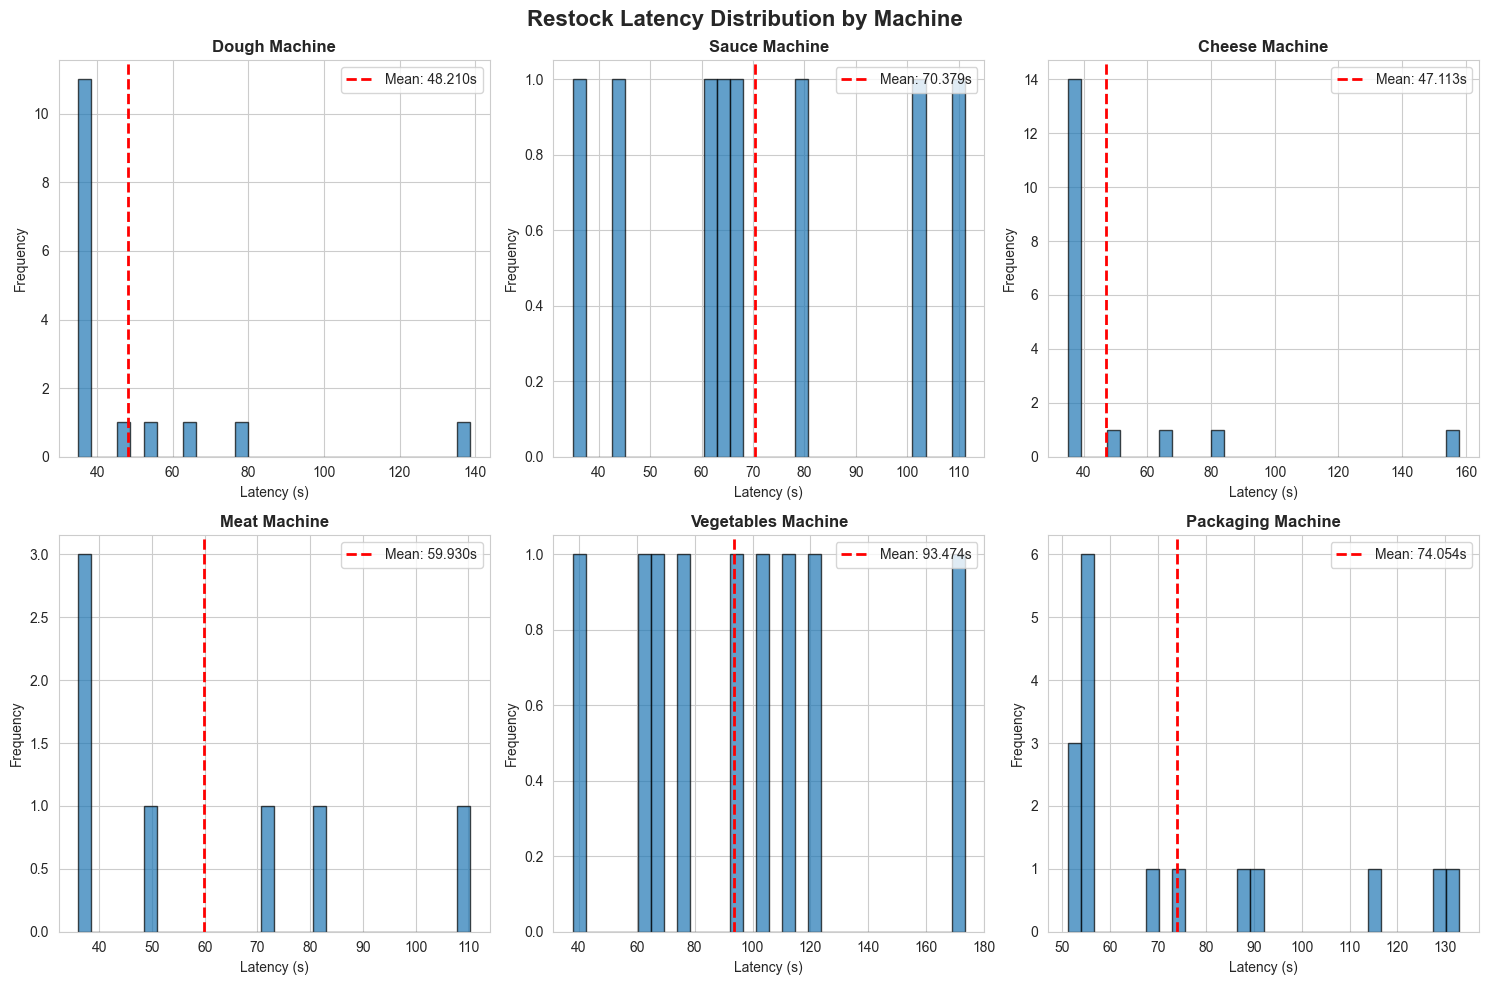

In [14]:
# ============================================================================
# 2. LATENCY DISTRIBUTION COMPARISON
# ============================================================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Restock Latency Distribution by Machine', fontsize=16, fontweight='bold')

for idx, (machine_name, df) in enumerate(all_machines.items()):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    ax.hist(df['RESTOCKLATENCYSEC'], bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(f'{machine_name.capitalize()} Machine', fontweight='bold')
    ax.set_xlabel('Latency (s)')
    ax.set_ylabel('Frequency')
    ax.axvline(df['RESTOCKLATENCYSEC'].mean(), color='red', 
               linestyle='--', linewidth=2, label=f'Mean: {df["RESTOCKLATENCYSEC"].mean():.3f}s')
    ax.legend()

plt.tight_layout()
plt.show()

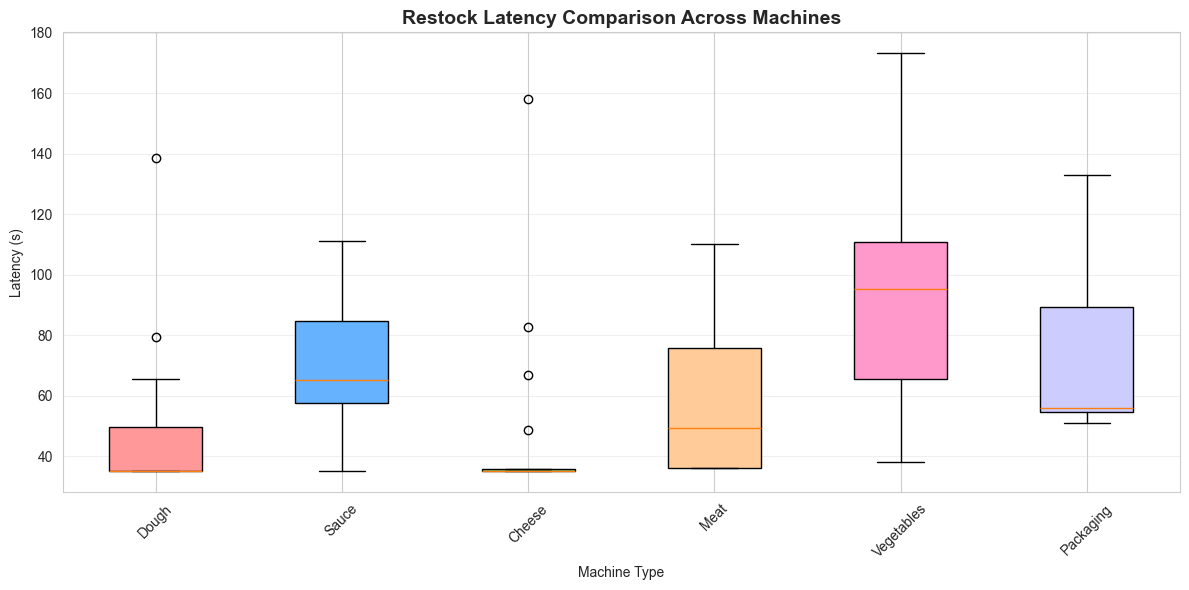

In [15]:
# ============================================================================
# 3. BOX PLOT COMPARISON
# ============================================================================
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for box plot
data_for_boxplot = []
labels = []
for machine_name, df in all_machines.items():
    data_for_boxplot.append(df['RESTOCKLATENCYSEC'])
    labels.append(machine_name.capitalize())

bp = ax.boxplot(data_for_boxplot, labels=labels, patch_artist=True)

# Color the boxes
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC', '#CCCCFF']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_title('Restock Latency Comparison Across Machines', fontsize=14, fontweight='bold')
ax.set_ylabel('Latency (s)')
ax.set_xlabel('Machine Type')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# ============================================================================
# 5. OUTLIER DETECTION
# ============================================================================
print("\n" + "=" * 80)
print("OUTLIER ANALYSIS (Values > 1.5 * IQR)")
print("=" * 80)

for machine_name, df in all_machines.items():
    Q1 = df['RESTOCKLATENCYSEC'].quantile(0.25)
    Q3 = df['RESTOCKLATENCYSEC'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df['RESTOCKLATENCYSEC'] < lower_bound) | 
                  (df['RESTOCKLATENCYSEC'] > upper_bound)]
    
    print(f"\n{machine_name.capitalize()} Machine:")
    print(f"  Outliers detected: {len(outliers)}")
    if len(outliers) > 0:
        print(f"  Outlier values (s): {sorted(outliers['RESTOCKLATENCYSEC'].tolist())}")



OUTLIER ANALYSIS (Values > 1.5 * IQR)

Dough Machine:
  Outliers detected: 2
  Outlier values (s): [79.346, 138.625]

Sauce Machine:
  Outliers detected: 0

Cheese Machine:
  Outliers detected: 4
  Outlier values (s): [48.808, 67.005, 82.583, 158.017]

Meat Machine:
  Outliers detected: 0

Vegetables Machine:
  Outliers detected: 0

Packaging Machine:
  Outliers detected: 0


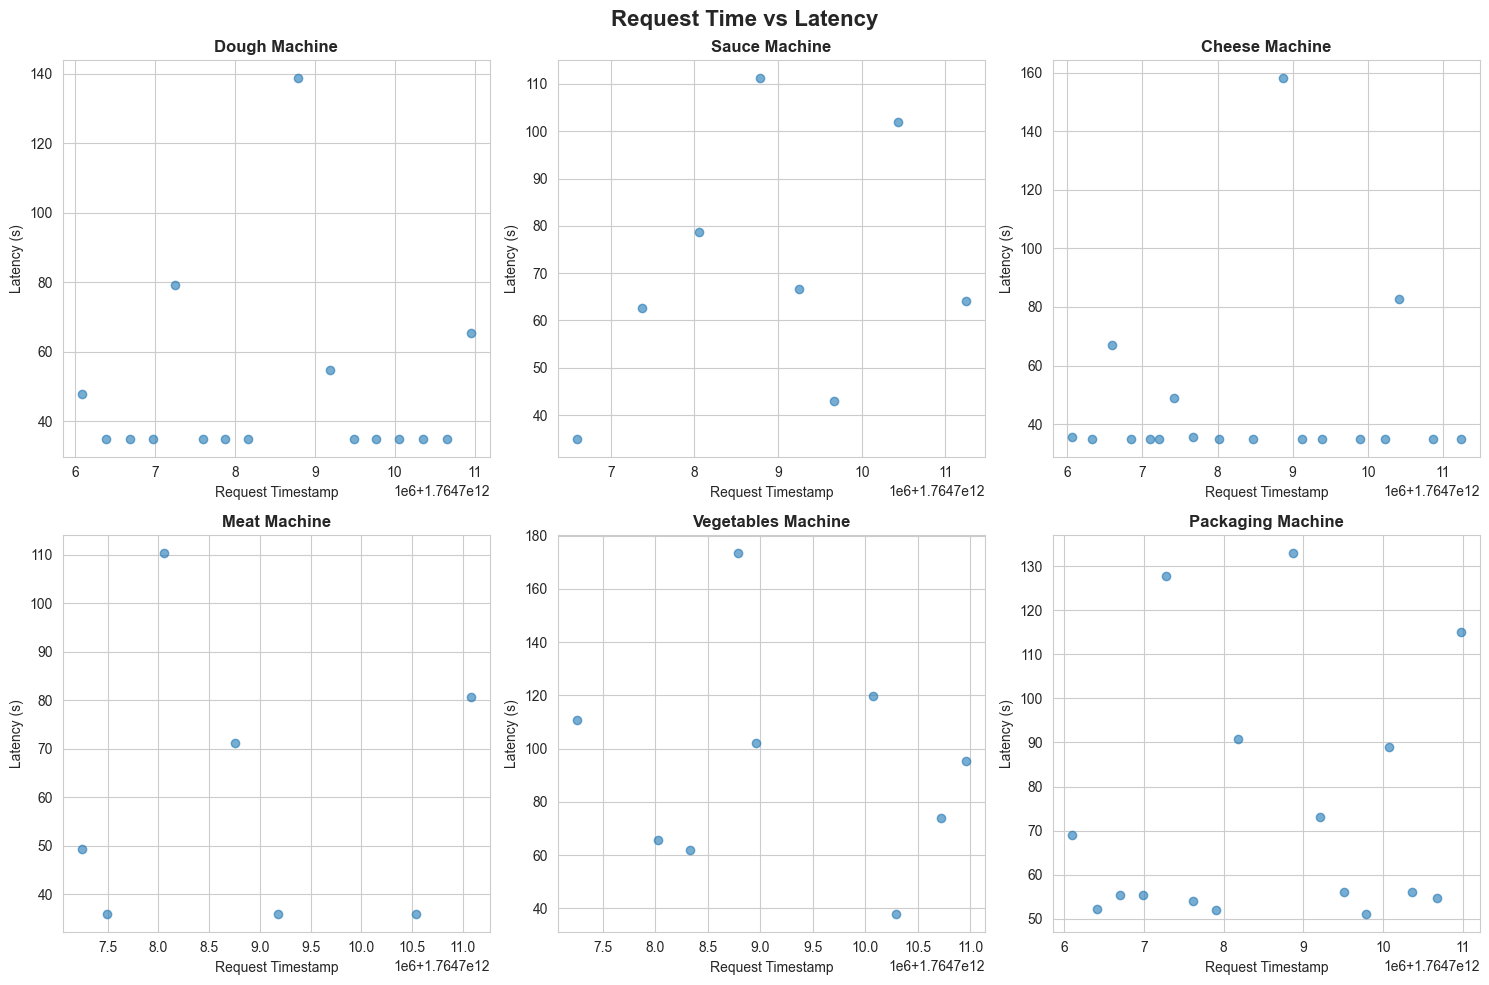

In [17]:
# ============================================================================
# 6. CORRELATION BETWEEN REQUEST TIME AND LATENCY
# ============================================================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Request Time vs Latency', fontsize=16, fontweight='bold')

for idx, (machine_name, df) in enumerate(all_machines.items()):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    ax.scatter(df['REQUESTTIMESTAMP'], df['RESTOCKLATENCYSEC'], alpha=0.6)
    ax.set_title(f'{machine_name.capitalize()} Machine', fontweight='bold')
    ax.set_xlabel('Request Timestamp')
    ax.set_ylabel('Latency (s)')

plt.tight_layout()
plt.show()


In [18]:
# ============================================================================
# 7. OVERALL COMPARISON TABLE
# ============================================================================
print("\n" + "=" * 80)
print("MACHINE RANKING BY PERFORMANCE METRICS")
print("=" * 80)

ranking_df = summary_df.copy()
ranking_df['Avg Rank'] = (
    ranking_df['Mean (s)'].rank() + 
    ranking_df['Median (s)'].rank() + 
    ranking_df['P95 (s)'].rank()
) / 3

ranking_df = ranking_df.sort_values('Avg Rank')
print("\n", ranking_df[['Machine', 'Mean (s)', 'Median (s)', 'P95 (s)', 'Avg Rank']].to_string(index=False))



MACHINE RANKING BY PERFORMANCE METRICS

    Machine  Mean (s)  Median (s)   P95 (s)  Avg Rank
    cheese 47.112944     35.0315  93.89810  1.000000
     dough 48.209688     35.0350  94.16575  2.000000
      meat 59.930143     49.3330 101.38740  3.000000
     sauce 70.379375     65.3120 107.88575  4.333333
 packaging 74.054000     56.0905 129.17025  4.666667
vegetables 93.473778     95.3270 151.88640  6.000000


## Global Analysis

In [19]:
first_timestamp=order_df['STARTTIMESTAMP'].min()
last_timestamp=order_df['ENDTIMESTAMP'].max()
total_duration_sec=(last_timestamp - first_timestamp)/1000
print(f"\nTotal Experiment Duration: {total_duration_sec:.2f} seconds ({total_duration_sec/60:.2f} minutes)")


Total Experiment Duration: 5454.19 seconds (90.90 minutes)


RESTOCK DURATION ANALYSIS
• Dough Machine Total Restock Duration: 771.36 seconds (12.86 minutes)
• Sauce Machine Total Restock Duration: 563.03 seconds (9.38 minutes)
• Cheese Machine Total Restock Duration: 848.03 seconds (14.13 minutes)
• Meat Machine Total Restock Duration: 419.51 seconds (6.99 minutes)
• Vegetables Machine Total Restock Duration: 841.26 seconds (14.02 minutes)
• Packaging Machine Total Restock Duration: 1184.86 seconds (19.75 minutes)

Overall Total Restock Duration: 4628.06 seconds (77.13 minutes)
Proportion of Total Experiment Time Spent on Restocking: 84.85%


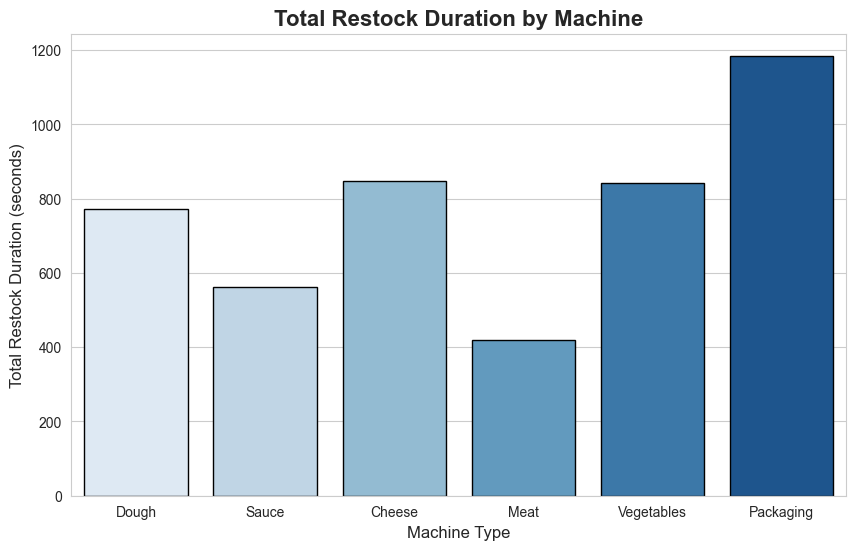

In [20]:
# Calculate restock duration for all machines
print("=" * 80)
print("RESTOCK DURATION ANALYSIS")
print("=" * 80)

for machine_name, df in all_machines.items():
    restock_duration_sec = sum(df['RESTOCKLATENCYSEC'])
    print(f"• {machine_name.capitalize()} Machine Total Restock Duration: {restock_duration_sec:.2f} seconds ({restock_duration_sec/60:.2f} minutes)")

total_restock_time = sum([sum(df['RESTOCKLATENCYSEC']) for df in all_machines.values()])
print(f"\nOverall Total Restock Duration: {total_restock_time:.2f} seconds ({total_restock_time/60:.2f} minutes)")
print(f"Proportion of Total Experiment Time Spent on Restocking: {total_restock_time/total_duration_sec*100:.2f}%")

# Bar chart of total restock durations
machine_names = []
restock_durations = []
for machine_name, df in all_machines.items():
    machine_names.append(machine_name.capitalize())
    restock_durations.append(sum(df['RESTOCKLATENCYSEC']))
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=machine_names, y=restock_durations, palette='Blues', edgecolor='black')
plt.title('Total Restock Duration by Machine', fontsize=16, fontweight='bold')
plt.xlabel('Machine Type', fontsize=12)
plt.ylabel('Total Restock Duration (seconds)', fontsize=12)
plt.show()

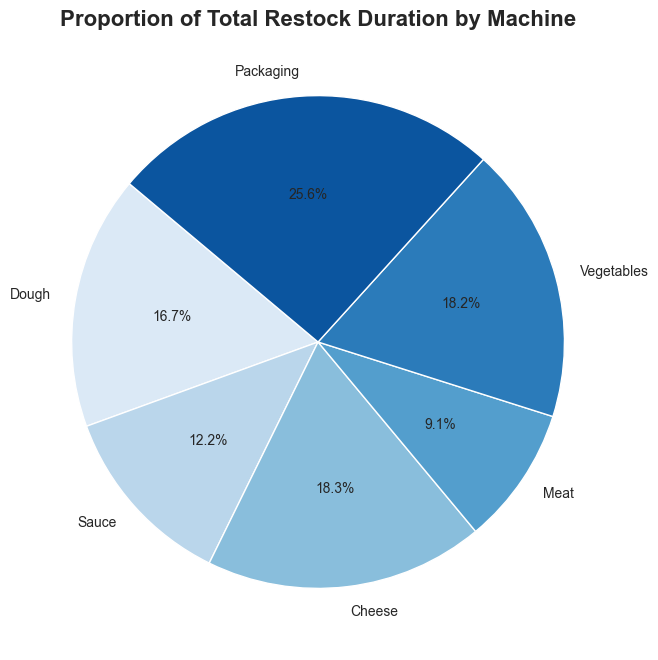

In [21]:
# Cake chart of restock duration proportions
plt.figure(figsize=(8, 8))
plt.pie(restock_durations, labels=machine_names, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Blues', len(machine_names)))
plt.title('Proportion of Total Restock Duration by Machine', fontsize=16, fontweight='bold')
plt.show()

In [22]:
print(f"Total Duration: {total_duration_sec}")
print(f"Total Restock Time: {total_restock_time}")
other_time = total_duration_sec - total_restock_time
print(f"Other Time: {other_time}")
print(f"Restock Durations: {restock_durations}")

Total Duration: 5454.188
Total Restock Time: 4628.062
Other Time: 826.1260000000002
Restock Durations: [771.355, 563.035, 848.033, 419.51099999999997, 841.264, 1184.864]


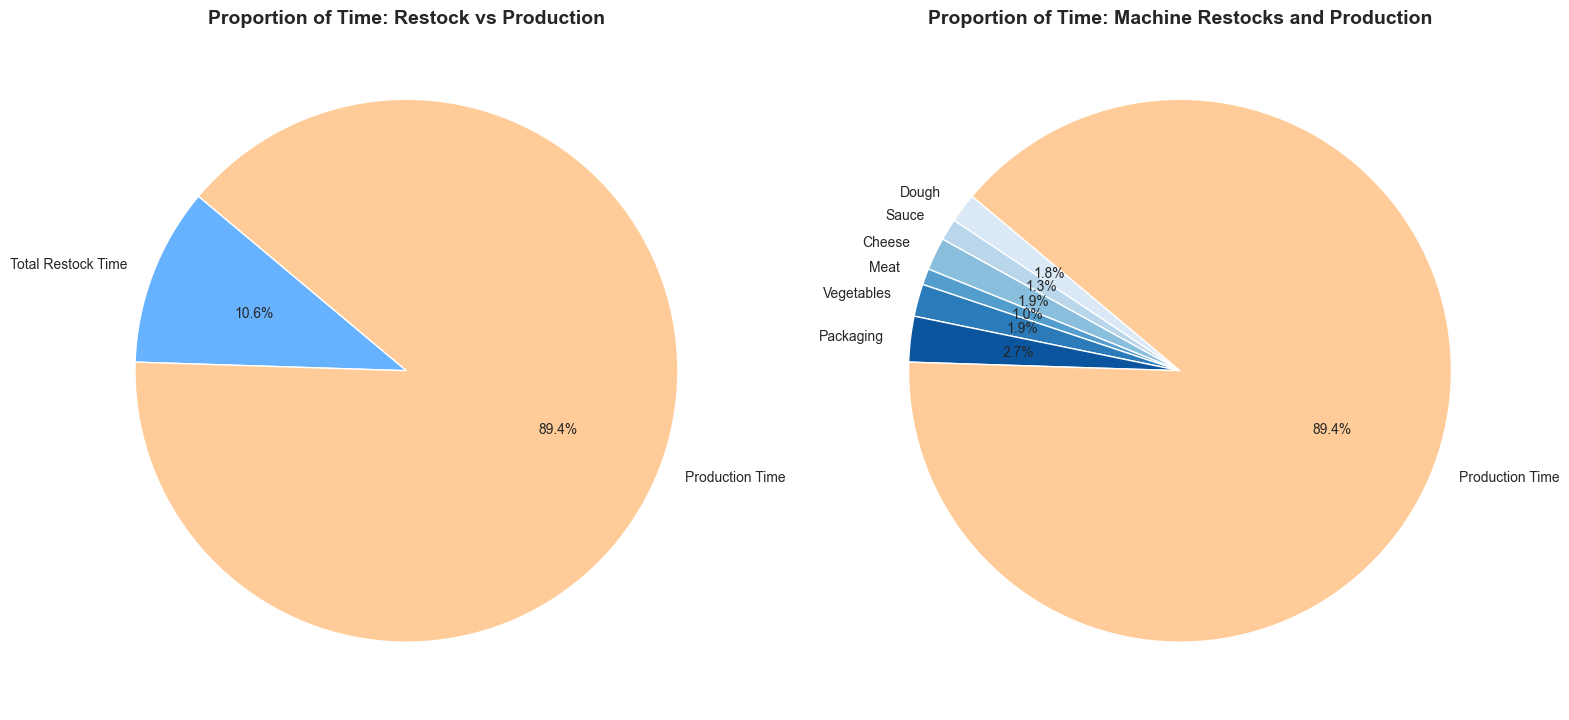

In [23]:
# Combine both pie charts in the same figure using subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left pie chart: Total Restock vs Production Time
other_time = pizza_production_time - total_restock_time
axes[0].pie([total_restock_time, other_time], 
            labels=['Total Restock Time', 'Production Time'], 
            autopct='%1.1f%%', 
            startangle=140, 
            colors=['#66B2FF', '#FFCC99'])
axes[0].set_title('Proportion of Time: Restock vs Production', fontsize=14, fontweight='bold')

# Right pie chart: Individual Machine Restocks and Production Time
items = restock_durations + [other_time]
labels = machine_names + ['Production Time']
axes[1].pie(items, 
            labels=labels, 
            autopct='%1.1f%%', 
            startangle=140, 
            colors=sns.color_palette('Blues', len(machine_names)) + ['#FFCC99'])
axes[1].set_title('Proportion of Time: Machine Restocks and Production', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Dispatch Analysis

In [24]:
# Load data
dispatch_df = pd.read_csv('./experiment-data/order_dispatch_latency.csv')


# Convert timestamps
for df in [dispatch_df]:
    df['START_TIME'] = pd.to_datetime(df['STARTTIMESTAMP'], unit='ms')
    df['END_TIME'] = pd.to_datetime(df['DISPATCHEDTIMESTAMP'], unit='ms', errors='coerce')
    
# Calculate latency in seconds
dispatch_df['LATENCY_S'] = (dispatch_df['END_TIME'] - dispatch_df['START_TIME']).dt.total_seconds()


In [25]:
# Summary statistics
print("=" * 60)
print("ORDER DISPATCHED LATENCY STATISTICS")
print("=" * 60)
print(f"\nMean: {dispatch_df['LATENCY_S'].mean():.2f}s")
print(f"Median: {dispatch_df['LATENCY_S'].median():.2f}s")
print(f"Std Dev: {dispatch_df['LATENCY_S'].std():.2f}s")
print(f"Min: {dispatch_df['LATENCY_S'].min():.2f}s")
print(f"Max: {dispatch_df['LATENCY_S'].max():.2f}s")

# Percentiles
percentiles = [25, 50, 75, 90, 95, 99]
print("\nPercentiles:")
for p in percentiles:
    val = np.percentile(dispatch_df['LATENCY_S'], p)
    print(f"  P{p}: {val:.2f}s")

# Group by order size
print("\n" + "=" * 60)
print("LATENCY BY ORDER SIZE")
print("=" * 60)
size_analysis2 = dispatch_df.groupby('ORDERSIZE').agg({
    'LATENCY_S': ['count', 'mean', 'median', 'std', 'min', 'max']
}).round(2)
size_analysis2.columns = ['Count', 'Mean(s)', 'Median(s)', 'Std(s)', 'Min(s)', 'Max(s)']
print(size_analysis2)

ORDER DISPATCHED LATENCY STATISTICS

Mean: 1362.77s
Median: 456.21s
Std Dev: 1663.94s
Min: 22.60s
Max: 5439.60s

Percentiles:
  P25: 74.22s
  P50: 456.21s
  P75: 2100.09s
  P90: 4128.06s
  P95: 4773.11s
  P99: 5299.93s

LATENCY BY ORDER SIZE
           Count  Mean(s)  Median(s)   Std(s)   Min(s)   Max(s)
ORDERSIZE                                                      
1             10    42.69      42.68    13.55    22.60    62.87
10            10   217.65     215.92    97.79    78.00   382.34
50            10  1271.25    1252.77   506.34   530.08  2022.38
100           10  3919.48    3944.52  1032.45  2333.23  5439.60


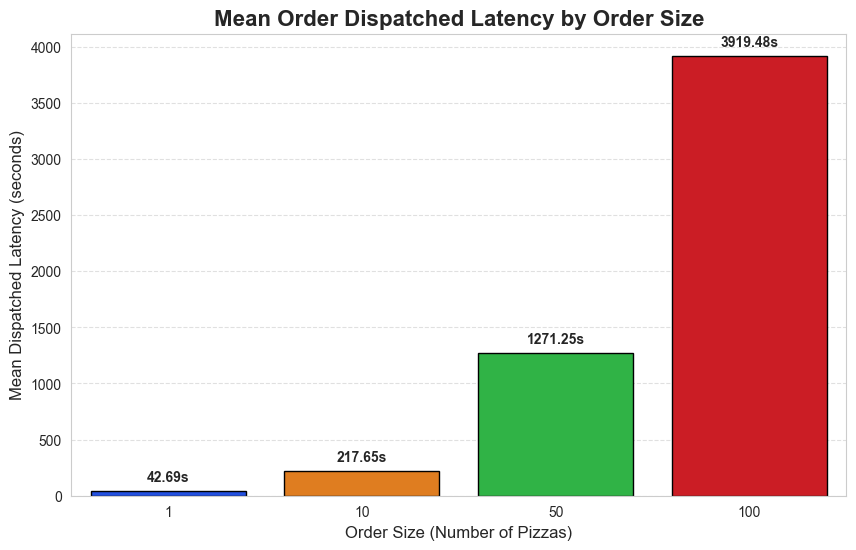

In [26]:
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(x=size_analysis2.index, y=size_analysis2['Mean(s)'], palette='bright', edgecolor='black')

plt.title('Mean Order Dispatched Latency by Order Size', fontsize=16, fontweight='bold')
plt.xlabel('Order Size (Number of Pizzas)', fontsize=12)
plt.ylabel('Mean Dispatched Latency (seconds)', fontsize=12)
# Add data labels to the bars
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}s', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

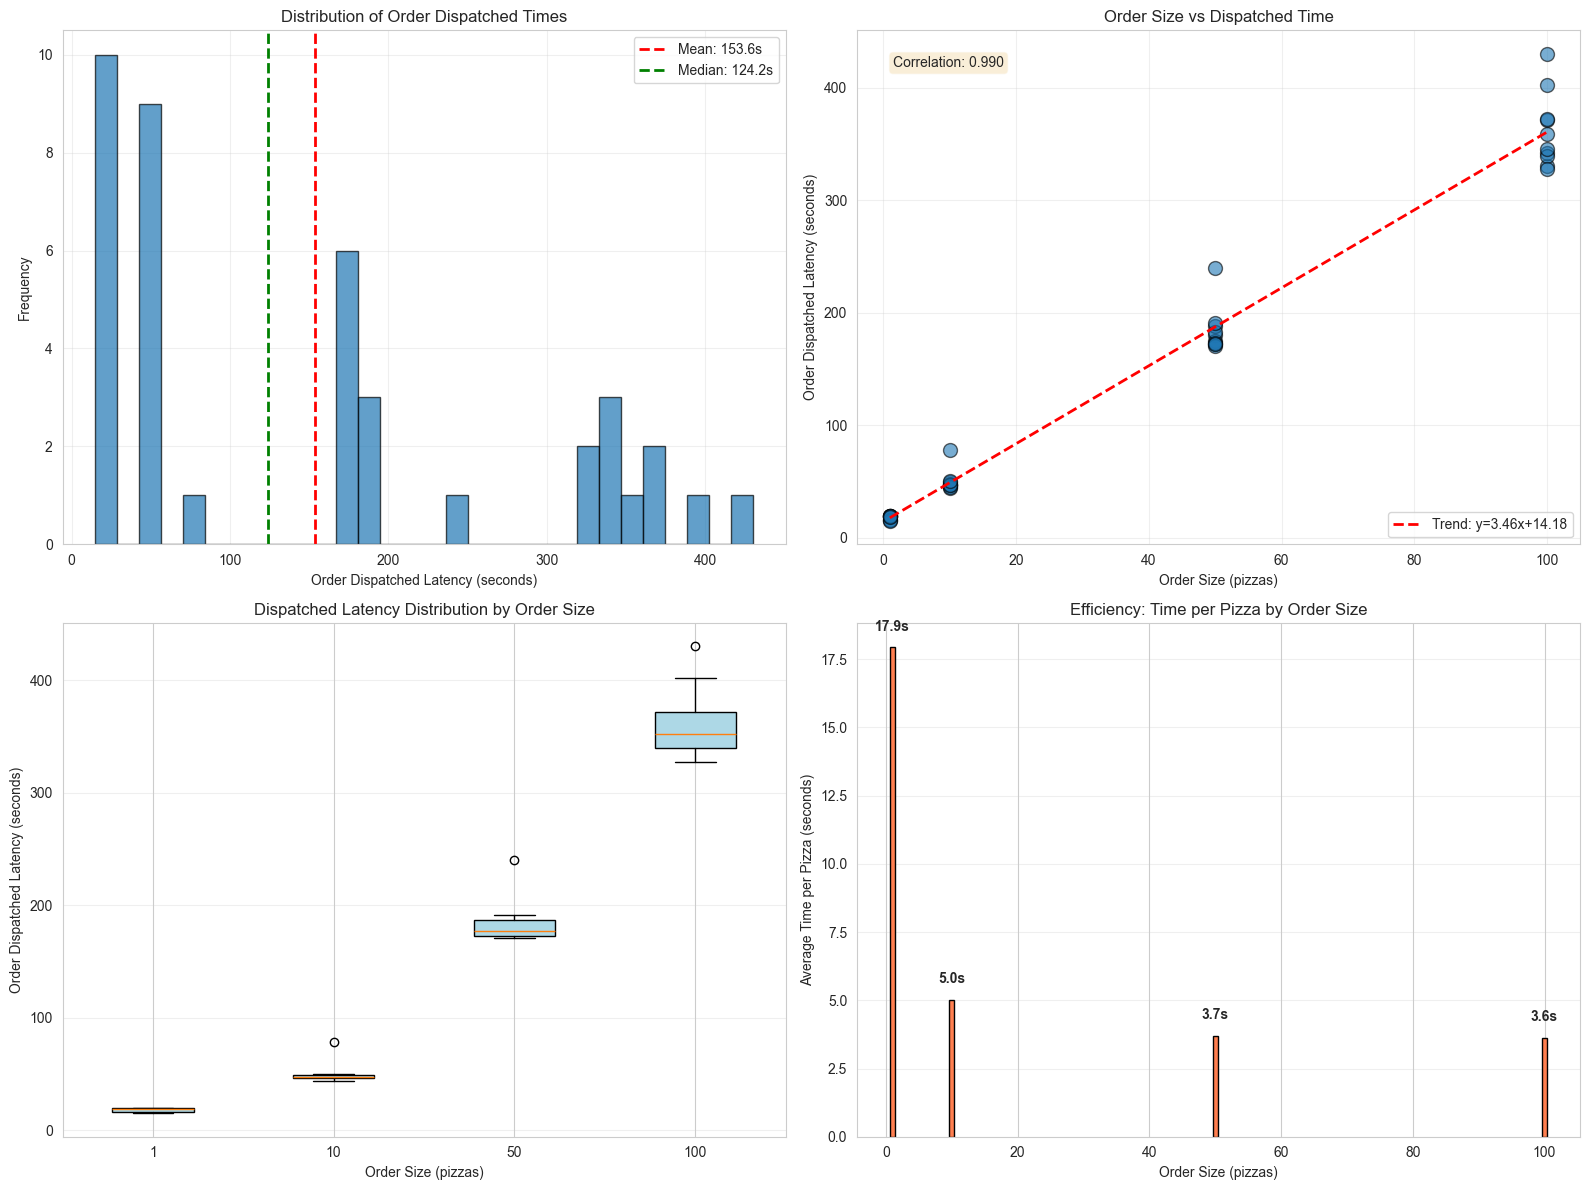

In [27]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of order latency
axes[0, 0].hist(completed_orders['LATENCY_S'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(completed_orders['LATENCY_S'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean: {completed_orders["LATENCY_S"].mean():.1f}s')
axes[0, 0].axvline(completed_orders['LATENCY_S'].median(), color='green', 
                   linestyle='--', linewidth=2, label=f'Median: {completed_orders["LATENCY_S"].median():.1f}s')
axes[0, 0].set_xlabel('Order Dispatched Latency (seconds)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Order Dispatched Times')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Order size vs latency (scatter with trend)
axes[0, 1].scatter(completed_orders['ORDERSIZE'], completed_orders['LATENCY_S'], 
                   alpha=0.6, s=100, edgecolors='black')
z = np.polyfit(completed_orders['ORDERSIZE'], completed_orders['LATENCY_S'], 1)
p = np.poly1d(z)
x_line = np.linspace(completed_orders['ORDERSIZE'].min(), completed_orders['ORDERSIZE'].max(), 100)
axes[0, 1].plot(x_line, p(x_line), "r--", linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
axes[0, 1].set_xlabel('Order Size (pizzas)')
axes[0, 1].set_ylabel('Order Dispatched Latency (seconds)')
axes[0, 1].set_title('Order Size vs Dispatched Time')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Calculate correlation
corr = completed_orders['ORDERSIZE'].corr(completed_orders['LATENCY_S'])
axes[0, 1].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                transform=axes[0, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Box plot by order size
order_sizes_sorted = sorted(completed_orders['ORDERSIZE'].unique())
data_for_box = [completed_orders[completed_orders['ORDERSIZE'] == size]['LATENCY_S'] 
                for size in order_sizes_sorted]
bp = axes[1, 0].boxplot(data_for_box, labels=order_sizes_sorted, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[1, 0].set_xlabel('Order Size (pizzas)')
axes[1, 0].set_ylabel('Order Dispatched Latency (seconds)')
axes[1, 0].set_title('Dispatched Latency Distribution by Order Size')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Average dispatched latency per pizza by order size
completed_orders['LATENCY_PER_PIZZA'] = completed_orders['LATENCY_S'] / completed_orders['ORDERSIZE']
avg_per_pizza = completed_orders.groupby('ORDERSIZE')['LATENCY_PER_PIZZA'].mean()
axes[1, 1].bar(avg_per_pizza.index, avg_per_pizza.values, color='coral', edgecolor='black')
axes[1, 1].set_xlabel('Order Size (pizzas)')
axes[1, 1].set_ylabel('Average Time per Pizza (seconds)')
axes[1, 1].set_title('Efficiency: Time per Pizza by Order Size')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, v in enumerate(avg_per_pizza.values):
    axes[1, 1].text(avg_per_pizza.index[i], v + 0.5, f'{v:.1f}s', 
                    ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()
